In [10]:
import sys
import warnings

sys.path.append("/workspaces/ood/")
%load_ext autoreload
%autoreload 2
warnings.filterwarnings("ignore")
from torch.utils.data import DataLoader
from train import FastflowTrainer
from omegaconf import OmegaConf
import numpy as np
import torch
from ood.ood_metrics import get_measures
from ood.utils import prettify_value
from anomalib.models.fastflow.model import FastflowModel, FastflowLightning
from tqdm import tqdm
from anomalib.config import get_configurable_parameters
from anomalib.data import get_datamodule
from anomalib.models import get_model
from albumentations.pytorch import ToTensorV2
import albumentations as A
from ood.draw import draw_score_distr_plot
import matplotlib.pyplot as plt
from anomalib.data.transforms import PreProcessor
from anomalib.data.mvtec import MVTec
from data import FeaturesTrainDataset, FeaturesDatasetOOD

device = torch.device("cuda")
torch.cuda.is_available()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

In [2]:
torch.cuda.set_device(1)
torch.cuda.current_device()

1

In [3]:
config = get_configurable_parameters(
    model_config_path="/workspaces/ood/anomalib/anomalib/models/fastflow/config.yaml",
    weight_file="/workspaces/ood/anomalib/results/fastflow/mvtec/ood/weights/model-v2.ckpt",
)

In [4]:
# pre_process = PreProcessor(image_size=(config.dataset.image_size[0], config.dataset.image_size[0]))
height = 256
width = 256
pre_process = A.Compose(
    [
        A.Resize(height=height, width=width, always_apply=True),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
pre_process_raw = A.Compose(
    [
        A.Resize(height=height, width=width, always_apply=True),
    ]
)

In [5]:
test_data = MVTec(
    root=config.dataset.path,
    category=config.dataset.category,
    split="test",
    pre_process=pre_process,
    task=config.dataset.task,
)
test_data_raw = MVTec(
    root=config.dataset.path,
    category=config.dataset.category,
    split="test",
    pre_process=pre_process_raw,
    task=config.dataset.task,
)
train_data = MVTec(
    root=config.dataset.path,
    category=config.dataset.category,
    split="train",
    pre_process=pre_process,
    task=config.dataset.task,
)

In [6]:
model = get_model(config).to(device)

CNF coder: 512
CNF coder: 1024
CNF coder: 2048


### Compute scores

In [7]:
in_anomaly_scores = []
out_anomaly_scores = []
for sample_idx in tqdm(range(len(test_data))):
    sample = test_data[sample_idx]
    image = torch.unsqueeze(torch.tensor(sample["image"]).float().to(device), dim=0)
    label = sample["label"]
    out = model(image)
    anomaly_score = out.detach().cpu().numpy().mean()
    if label == 0:
        in_anomaly_scores.append(anomaly_score)
    else:
        out_anomaly_scores.append(anomaly_score)

100%|██████████| 2000/2000 [01:31<00:00, 21.76it/s]


In [16]:
in_anomaly_scores_train = []
for sample_idx in tqdm(range(len(train_data))):
    sample = train_data[sample_idx]
    image = torch.unsqueeze(torch.tensor(sample["image"]).float().to(device), dim=0)
    out = model(image)
    anomaly_score = out.detach().cpu().numpy().mean()
    in_anomaly_scores_train.append(anomaly_score)

100%|██████████| 10000/10000 [07:43<00:00, 21.57it/s]


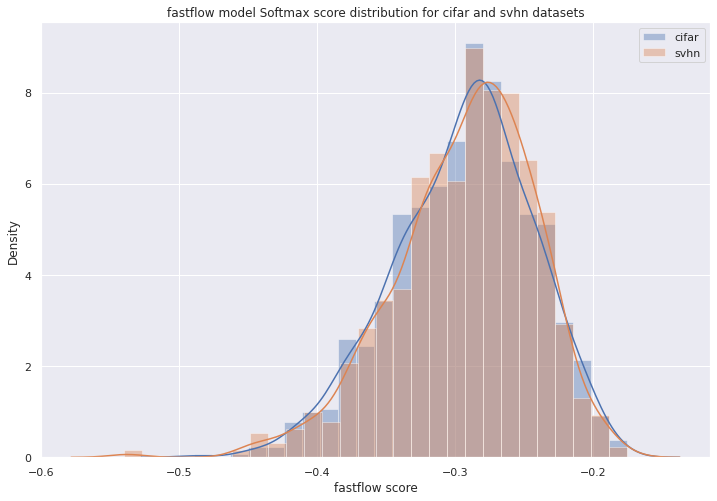

In [13]:
model_name = "fastflow"
scores_distr = {
    "cifar": -np.array(in_anomaly_scores),
    "svhn": -np.array(out_anomaly_scores),
}
draw_score_distr_plot(
    scores_distr=scores_distr,
    score_type="fastflow",
    model_name=model_name,
    in_data_name="cifar",
    out_data_name="svhn",
)

In [14]:
auroc, aupr, fpr = get_measures(scores_distr["cifar"], scores_distr["svhn"])
auroc, aupr, fpr = prettify_value((auroc, aupr, fpr), num_round=5, ljust_num=7)

print(f" {model_name} softmax scores: \n auroc {auroc}\n aupr  {aupr}\n FPR95 {fpr}")

 fastflow softmax scores: 
 auroc 0.48659
 aupr  0.49777
 FPR95 0.95300


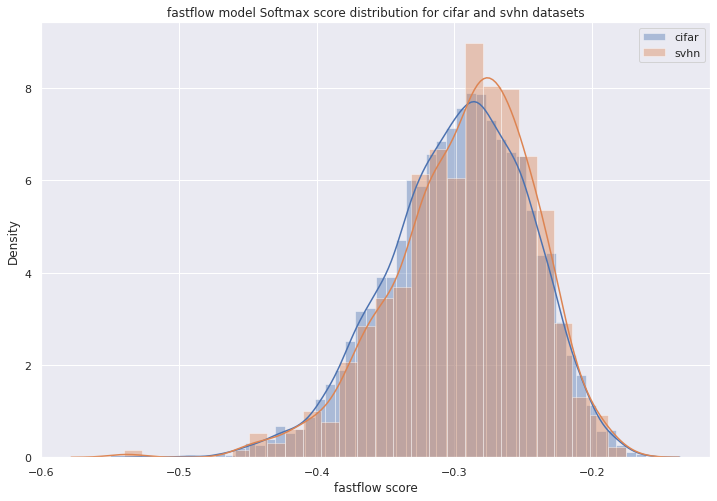

In [17]:
model_name = "fastflow"
scores_distr = {
    "cifar": -np.array(in_anomaly_scores_train),
    "svhn": -np.array(out_anomaly_scores),
}
draw_score_distr_plot(
    scores_distr=scores_distr,
    score_type="fastflow",
    model_name=model_name,
    in_data_name="cifar",
    out_data_name="svhn",
)

### Vis model pred

<ipython-input-124-1fb451b824c9>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.unsqueeze(torch.tensor(test_data[idx]['image']).float().to(device), dim=0)


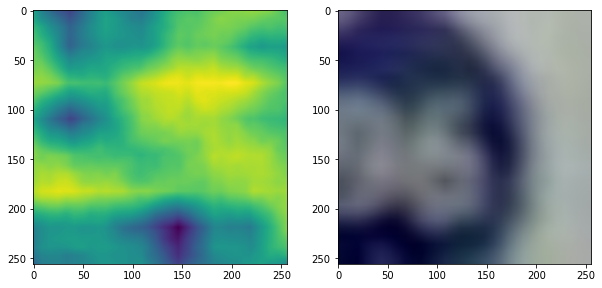

In [124]:
plt.figure(figsize=(10, 15))
idx = 1024
image = torch.unsqueeze(torch.tensor(test_data[idx]["image"]).float().to(device), dim=0)
out = model(image)
ax1 = plt.subplot(121)
ax1.imshow(out.detach().cpu())
ax2 = plt.subplot(122)
# image_to_show = np.moveaxis(test_data[5]['image'], 0, -1)
ax2.imshow(test_data_raw[idx]["image"])